In [1]:
from pathlib import Path

from karateclub.graph_embedding import Graph2Vec
import networkx as nx
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
graphs = []
path_to_graphs_folder = Path("./graphs")
dict_class = {}
class_list = []
for path_to_matlab_file in tqdm(path_to_graphs_folder.iterdir()):
    mat = loadmat(str(path_to_matlab_file))
    graph = mat["conmatT"][:, :, 0]
#     graph[graph > 0] = 1
    nx_graph = nx.from_numpy_array(graph)

    if not nx.is_connected(nx_graph):
        continue

    graphs.append(nx_graph)

    class_string = path_to_matlab_file.stem.split('_')[0]
    if class_string[-1].isdigit():
        class_string = class_string[:-1]

    if not dict_class.get(class_string, False):
        dict_class[class_string] = len(set(class_list))

    class_list.append(class_string)

class_list_number = [dict_class[i] for i in class_list]

print('number of graphs {}'.format(len(graphs)))
print('number of filtered graphs {}'.format(len(list(path_to_graphs_folder.iterdir())) - len(graphs)))

226it [00:09, 23.52it/s]

number of graphs 202
number of filtered graphs 24


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 202 samples in 0.000s...
[t-SNE] Computed neighbors for 202 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 202 / 202
[t-SNE] Mean sigma: 0.004244
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.698730
[t-SNE] Error after 500 iterations: 1.245968


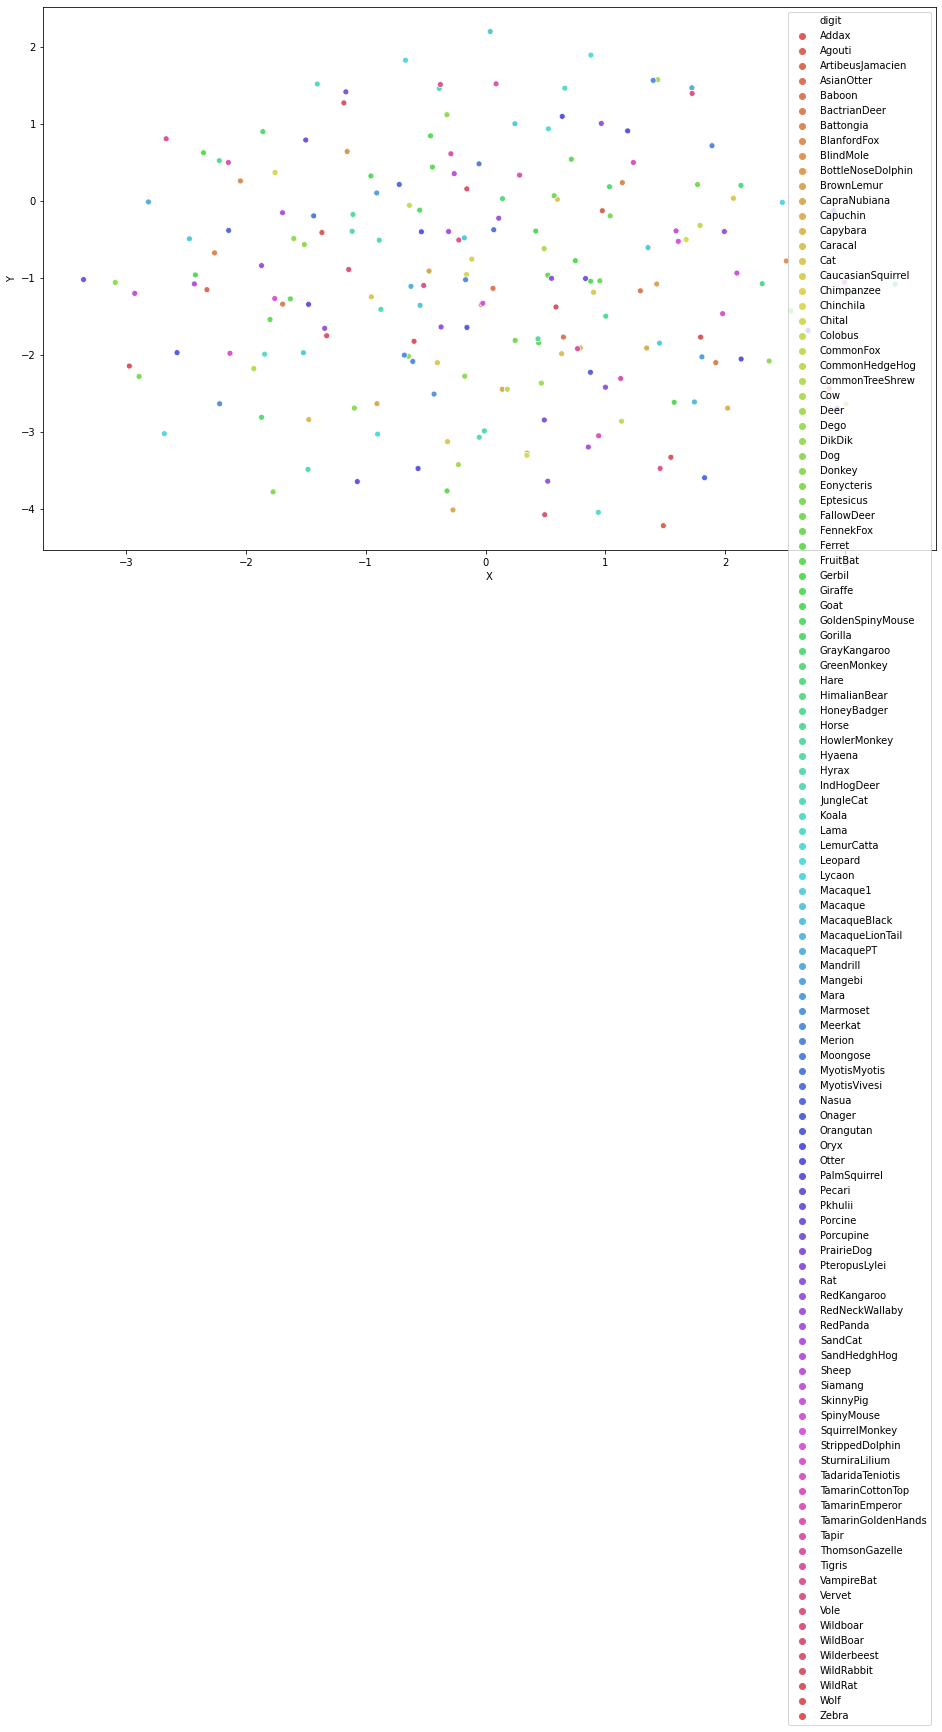

In [9]:
model = Graph2Vec(dimensions=300)
model.fit(graphs)
model.get_embedding()

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(model.get_embedding())

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(model.get_embedding())

tsne_df = pd.DataFrame({'X': tsne_results[:, 0],
                        'Y': tsne_results[:, 1],
                        'digit': class_list})

plt.figure(figsize=(16, 10))
plot = sns.scatterplot(
    x="X", y="Y",
    hue="digit",
    palette=sns.color_palette("hls", len(dict_class.keys())),
    data=tsne_df,
    legend="full"
)

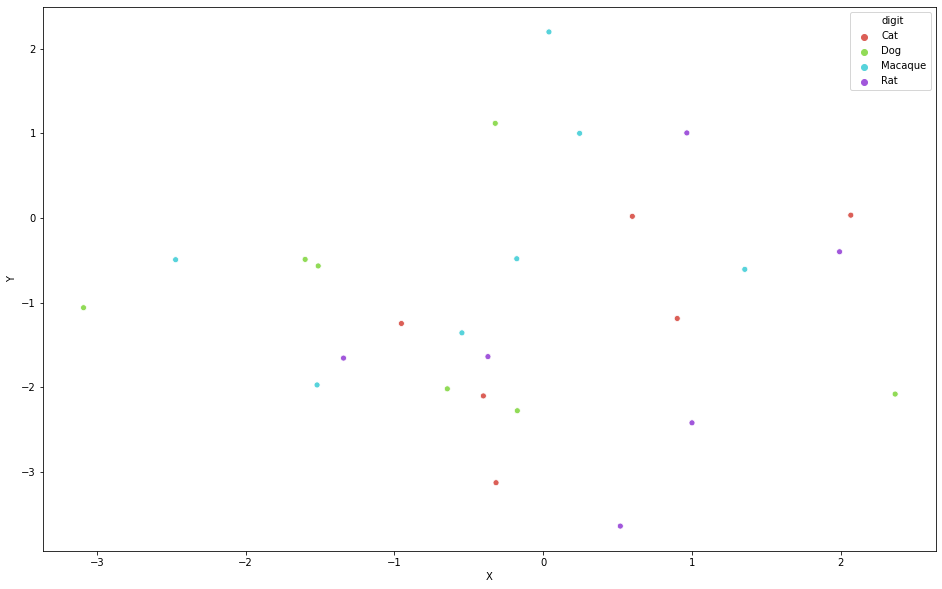

In [10]:
values, counts = np.unique(class_list, return_counts=True)
total_dict = {val: count for val, count in zip(values, counts)}
total_dict2 = {k: v for k, v in sorted(total_dict.items(), key=lambda item: item[1], reverse=True)}

small_df = tsne_df[tsne_df['digit'].isin([list(total_dict2.keys())[0],
                                               list(total_dict2.keys())[1],
                                               list(total_dict2.keys())[2],
                                               list(total_dict2.keys())[3]])]

plt.figure(figsize=(16, 10))
plot = sns.scatterplot(
    x="X", y="Y",
    hue="digit",
    palette=sns.color_palette("hls", 4),
    data=small_df,
    legend="full"
)